In [1]:
import sys

from absl import flags
from ml_collections import config_flags
from collections import defaultdict
import tqdm
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

import tensorflow as tf
import random
import jax
import jax.numpy as jnp
import numpy as np

from agents import agents
from utils.env_utils import make_env_and_datasets
from utils.flax_utils import restore_agent

2025-07-28 14:57:55.910040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-28 14:57:55.910136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-28 14:57:55.937881: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-28 14:57:56.004623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-28 14:57:58.427771: W tensorflow/compiler/tf2

In [2]:
FLAGS = flags.FLAGS

flags.DEFINE_string('env_name', 'google_robot_pick_coke_can', 'Environment (dataset) name.')
flags.DEFINE_integer('seed', 0, 'Random seed.')
flags.DEFINE_float('p_aug', 0.5, 'Probability of applying image augmentation.')
flags.DEFINE_integer('num_aug', 1, 'Number of image augmentations.')
flags.DEFINE_integer('inplace_aug', 1, 'Whether to replace the original image after applying augmentations.')
flags.DEFINE_integer('frame_stack', 3, 'Number of frames to stack.')
config_flags.DEFINE_config_file('agent', '../impls/agents/vqvae.py', lock_config=False)

if not FLAGS.is_parsed():
    FLAGS(sys.argv, known_only=True)

config = FLAGS.agent
config['encoder'] = 'resnet_34'
config['decoder'] = 'resnet_34'
_, _, train_dataset, val_dataset = make_env_and_datasets(
    FLAGS.env_name, frame_stack=FLAGS.frame_stack, max_size=10_000_000, action_clip_eps=None)

# Initialize agent.
random.seed(FLAGS.seed)
np.random.seed(FLAGS.seed)
tf.random.set_seed(FLAGS.seed)

# Set up datasets.
train_dataset = (
    train_dataset
    .shuffle(20_000)
    .repeat()
    .batch(config['batch_size'])
    .prefetch(tf.data.AUTOTUNE)
)
train_dataset_iter = train_dataset.as_numpy_iterator()
val_dataset = (
    val_dataset
    .shuffle(2_000)
    .repeat()
    .batch(config['batch_size'])
    .prefetch(tf.data.AUTOTUNE)
)
val_dataset_iter = val_dataset.as_numpy_iterator()

example_batch = next(val_dataset_iter)

agent_class = agents[config['agent_name']]
agent = agent_class.create(
    FLAGS.seed,
    example_batch['observations'],
    example_batch['actions'],
    config,
)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
/home/cz8792/.conda/envs/ogbench/lib/python3.10/site-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(version) <
/home/cz8792/.conda/envs/ogbench/lib/python3.10/site-packages/reverb/platform/default/ensure_tf_install.py:54: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  distutils.version.LooseVersion(required_tensorflow_version)):
/home/cz8792/.conda/envs/ogbench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cz8792/.conda/envs/ogbench/lib/python3.10/site-p

In [17]:
restore_path = '/home/cz8792/gpfs/exp_logs/ogbench_logs/vqvae/20250727_vqvae_google_robot_pick_coke_can/10/debug/sd010_s_66319823.0.20250727_165712'
restore_epoch = 300000

agent_class = agents[config['agent_name']]
agent = agent_class.create(
    FLAGS.seed,
    example_batch['observations'],
    example_batch['actions'],
    config,
)
agent = restore_agent(agent, restore_path, restore_epoch)

Restored from /home/cz8792/gpfs/exp_logs/ogbench_logs/vqvae/20250727_vqvae_google_robot_pick_coke_can/10/debug/sd010_s_66319823.0.20250727_165712/params_300000.pkl


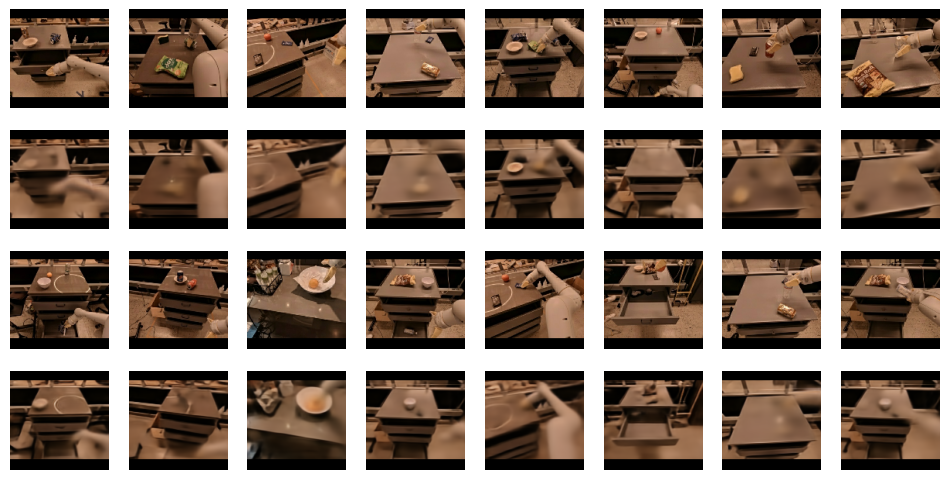

In [ ]:
num_recon_images = 16
num_cols = 8

val_batch = next(val_dataset_iter)
images = val_batch['observations']

recon_images = agent.reconstruct(images)  # use the original image as inputs
images = images.astype(jnp.float32) / 127.5 - 1.0  # put inputs in [-1, 1]
images = images.reshape([*images.shape[:-1], -1, 3])
recon_images = recon_images.reshape([*recon_images.shape[:-1], -1, 3])

images = jnp.clip((images + 1.0) / 2.0, 0.0, 1.0)
recon_images = jnp.clip((recon_images + 1.0) / 2.0, 0.0, 1.0)

# plot comparison with matplotlib. put each reconstruction side by side.
fig, axes = plt.subplots((num_recon_images // num_cols) * 2, num_cols, figsize=(12, 6))
for row in range(num_recon_images // num_cols):
    for col in range(num_cols):
        axes[2 * row, col].imshow(images[row * num_cols + col, :, :, 0], vmin=0.0, vmax=1.0)
        axes[2 * row + 1, col].imshow(recon_images[row * num_cols + col, :, :, 0], vmin=0.0, vmax=1.0)

        axes[2 * row, col].axis('off')
        axes[2 * row + 1, col].axis('off')

fig.show()
